In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3 import PPO


from fitness_functions import fitness_ESM, fitness_ESM_DMS
from callbacks import *

/home/kspiv/.conda/envs/rl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ProteinEnv(gym.Env):
    """
    State: amino acid sequence (string or int array)
    Action: mutate position i to amino acid j
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, seq, fitness_fn, DMS_path):
        ''' Requires the wild-type aa sequence (string), 
                fitness_fn (defined in fitness_functions.py),
            and DMS dataset (path to csv)
        '''
        super().__init__()
        self.amino_acids = "ACDEFGHIKLMNPQRSTVWY"
        self.aa_to_idx = {aa: i for i, aa in enumerate(self.amino_acids)}
        self.idx_to_aa = {i: aa for aa, i in self.aa_to_idx.items()}

        self.L = len(seq)
        self.fitness_fn = fitness_fn
        self.DMS = pd.read_csv(DMS_path)
        
        # convert sequence string → array of indices
        self.wt = np.array([self.aa_to_idx[a] for a in seq], dtype=np.int32)

        # action = choose a position to mutate, and choose an aa to mutate to
        self.action_space = spaces.Discrete(self.L * 20)   # talk about indel limitation in write-up

        # observation = vector of length L with values in [0,19]
        self.observation_space = spaces.MultiDiscrete([20] * self.L)

        self.state = None
    
    def idxs_to_letters(self, seq):
        ''' convert string of indexes to string of aa letters '''
        return ''.join([self.idx_to_aa[i] for i in seq])

    def _decode_action(self, action):
        pos = action // 20
        aa_idx = action % 20
        return pos, aa_idx

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.wt.copy()  # back to wild-type
        obs = self.state.copy()
        return obs, {}

    def step(self, action):
        # import pdb;pdb.set_trace()
        pos, aa_idx = self._decode_action(action)
        print(f'Pos: {pos} and aa_idx: {aa_idx}')

        # Apply mutation
        new_state = self.state.copy()
        new_state[pos] = aa_idx

        # Reward from fitness function
        reward = self.fitness_fn(self.idxs_to_letters(self.wt), self.idxs_to_letters(new_state), self.DMS)

        # You can choose episode termination rule:
        # e.g., fixed length episode of mutations
        terminated = False
        truncated = False

        self.state = new_state
        print(self.idxs_to_letters(new_state))
        return new_state.copy(), reward, terminated, truncated, {}

    def render(self):
        seq_str = "".join(self.idx_to_aa[i] for i in self.state)
        print(seq_str)


Using cpu device


/home/kspiv/.conda/envs/rl/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 4`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=4 and n_envs=1)
  warnings.warn(
Training PPO:   0%|          | 0/4 [00:00<?, ?it/s]

Pos: 289 and aa_idx: 3


Training PPO:  25%|██▌       | 1/4 [00:08<00:24,  8.14s/it]

MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCEFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL
Pos: 527 and aa_idx: 13


Training PPO:  50%|█████     | 2/4 [00:28<00:28, 14.47s/it]

MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCEFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKQDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL
Pos: 102 and aa_idx: 12


Training PPO:  75%|███████▌  | 3/4 [00:56<00:18, 18.86s/it]

MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQEPLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCEFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKQDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL
Pos: 599 and aa_idx: 13


Training PPO: 100%|██████████| 4/4 [01:28<00:00, 22.11s/it]

MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQEPLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCEFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKQDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGQLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL
[Rollout 1] avg_reward=-5.11, top_reward=-5.11
---------------------------
| time/              |    |
|    fps             | 0  |
|    iterations      | 1  |
|    time_elapsed    | 88 |
|    total_timesteps | 4  |
---------------------------


Training PPO: 100%|██████████| 4/4 [01:28<00:00, 22.23s/it]


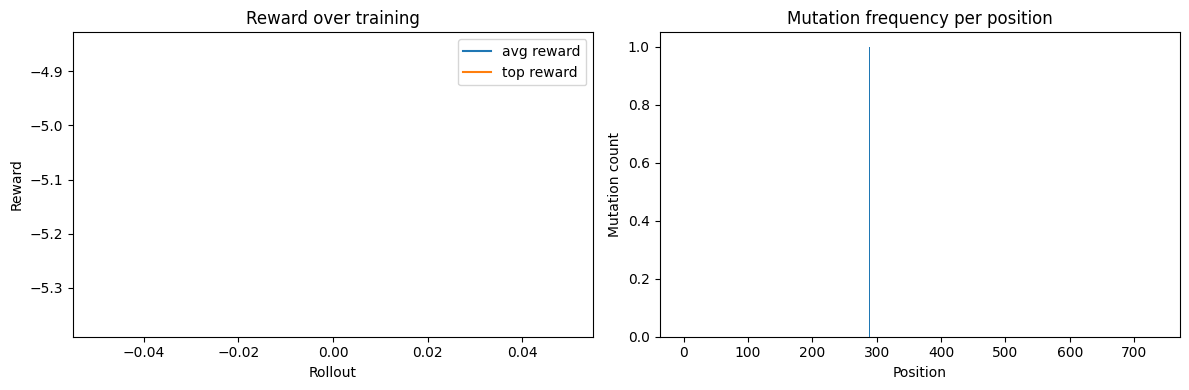

In [3]:
with open('aav_wt.txt', 'r') as file:
    wt = file.readline().strip()

def make_env():
    # Provide your own initial sequence + fitness_fn
    return ProteinEnv(wt, fitness_ESM, 'aav_dms.csv')

vec_env = DummyVecEnv([make_env])

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=3e-4,
    n_steps=4,  # 512
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    clip_range=0.2,
    verbose=1,
    device="cpu"
)

total_timesteps = 4
tqdm_cb = TQDMCallback(total_timesteps=total_timesteps, algo='PPO')
logger_cb = ProteinRLLogger(check_freq=1)
callback = CallbackList([tqdm_cb, logger_cb])
model.learn(total_timesteps=total_timesteps, callback=callback)
model.save("ppo_pretraining")

In [5]:
import pickle
with open('debug.pkl', 'rb') as file:
    debug = pickle.load(file)

all = debug['all_rewards']
mut = debug['mut']

In [9]:
np.nonzero(mut)

(array([102, 289, 527, 599]),)

AttributeError: 'Axes' object has no attribute 'xlabel'

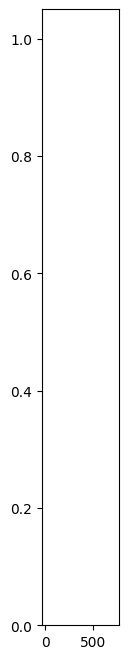

In [18]:
# plt.subplot(1,1, figsize=(8, 8))
fig, ax = plt.subplots(figsize=(1, 8))
# fig = plt.figure(figsize=(10, 6)) # 10 inches wide, 6 inches high
ax.bar(range(len(wt)), mut)
ax.xlabel("Position")
ax.ylabel("Mutation count")
ax.title("Mutation frequency per position")
# plt.tight_layout()
# plt.savefig(os.path.join(self.save_path, "protein_training_metrics.png"))
plt.figsize(10)
plt.show()

In [16]:
def levenshtein_distance(s, t):
    m, n = len(s), len(t)
    d = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        d[i][0] = i
    for j in range(n + 1):
        d[0][j] = j

    for j in range(1, n + 1):
        for i in range(1, m + 1):
            cost = 0 if s[i - 1] == t[j - 1] else 1
            d[i][j] = min(d[i - 1][j] + 1,      # Deletion
                          d[i][j - 1] + 1,      # Insertion
                          d[i - 1][j - 1] + cost) # Substitution

    return d[m][n]

string1 = wt
string2 = "MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGADKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRFWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCHFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQVLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL"
distance = levenshtein_distance(string1, string2)
print(f"The Levenshtein distance is: {distance}")

The Levenshtein distance is: 3
